In [2]:
import importlib
import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import DS9Converter, rotate_image, align_images
from uvotimgpy.uvot_image.star_cleaner import BackgroundCleaner
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

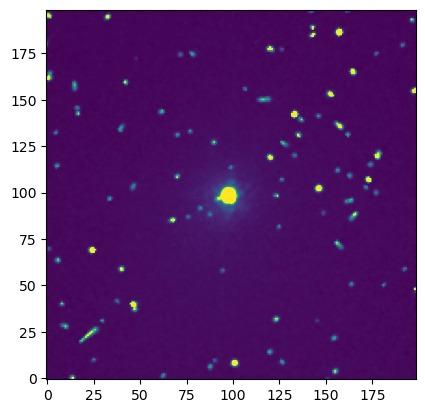

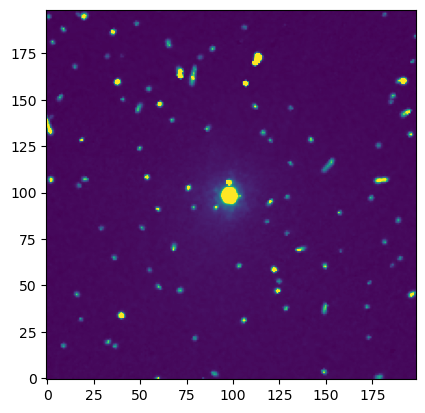

In [4]:
img_dict = {'18':(760,872),
            #'20':(773,884),
            '24':(766,877),
            #'26':(778,889)
            }
img_list = []
target_list = []
for imgid in img_dict.keys():
    x, y = img_dict[imgid]
    hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/'+imgid+'.fits')
    img = hdul[1].data
    angle = float(hdul[1].header['ORIENTAT'])
    col, row = DS9Converter.ds9_to_coords(x, y)[2:]
    target_list.append((col, row))

    img = rotate_image(img, target_coord=(col, row), angle=angle, fill_value=np.nan)
    img_list.append(img)

new_source_coord_ds9 = (100,100)
col, row = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_list = align_images(img_list, target_list, (col, row))

for img in img_list:
    plt.imshow(img, vmin=0, vmax=2, origin='lower')
    plt.show()

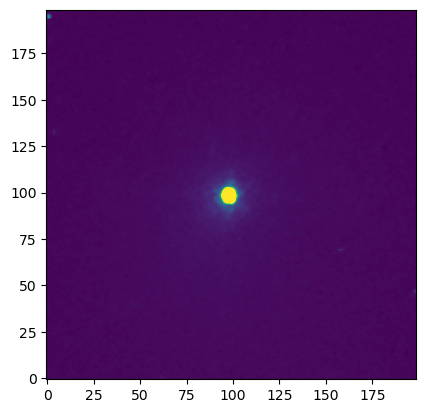

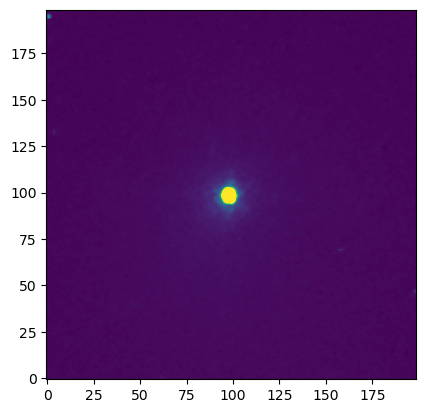

In [5]:
img_a = img_list[0]
img_b = img_list[1]
cleaner = BackgroundCleaner()
cleaned_a, cleaned_b = cleaner.process_image_pair(img_a, img_b)

plt.imshow(cleaned_a, vmin=0, vmax=2, origin='lower')
plt.show()

plt.imshow(cleaned_b, vmin=0, vmax=2, origin='lower')
plt.show()


The two images are almost the same, which indicates a over-mask.

In [3]:
import importlib
import uvotimgpy.utils.image_operation
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.utils.image_operation)
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.utils.image_operation import DS9Converter, crop_image
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier, PixelFiller
from uvotimgpy.base.visualizer import MaskInspector
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

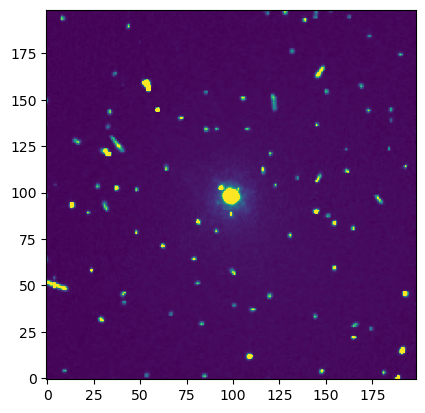

In [6]:
#hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/18.fits')
#x, y = 760, 872
img = hdul[1].data
col, row = DS9Converter.ds9_to_coords(x, y)[2:]
new_source_coord_ds9 = (100,100)
col_new, row_new = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_cropped = crop_image(img, (col, row), (col_new, row_new))

plt.imshow(img_cropped, vmin=0, vmax=2, origin='lower')
plt.show()

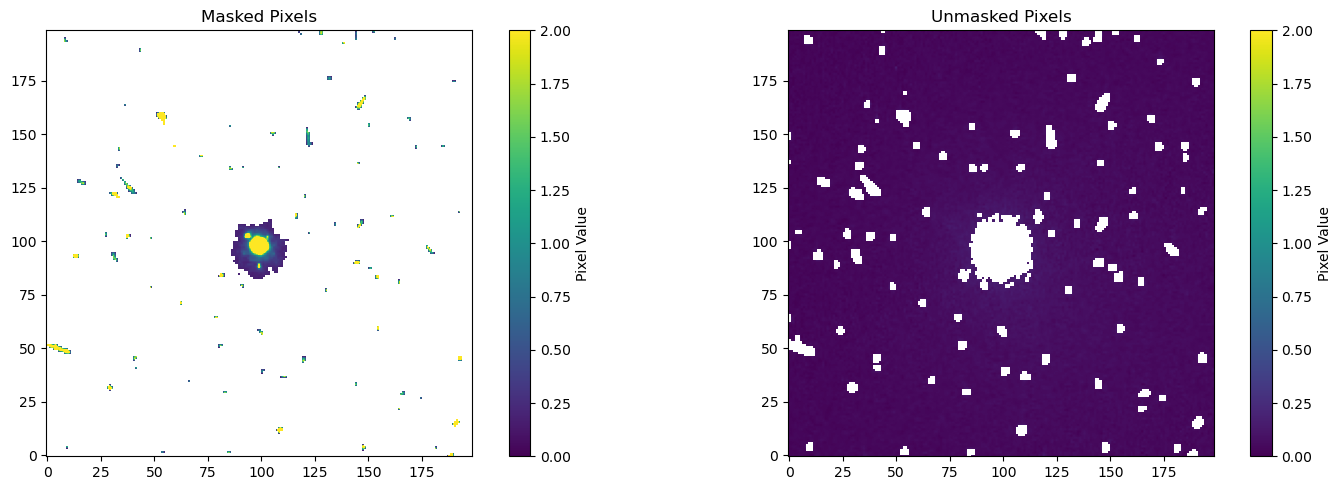

In [7]:
identifier = StarIdentifier()
mask = identifier.by_sigma_clip(img_cropped)

from uvotimgpy.base.visualizer import MaskInspector
inspector = MaskInspector(img_cropped, mask)
inspector.show_comparison(vmin=0,vmax=2)

sigma-clip

In [8]:
def plotRing(r, center, color='r', ls='-',lw=0.5,alpha=1):
    theta = np.arange(0,2*np.pi,0.01)
    if isinstance(r, np.ndarray):
        for ri in r:
            plt.plot(ri*np.cos(theta)+center[0],ri*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)
    else:
        plt.plot(r*np.cos(theta)+center[0],r*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)

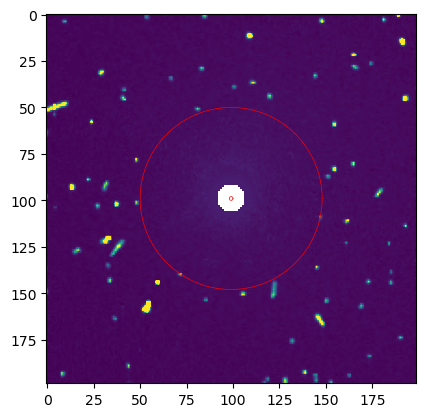

In [11]:
filler = PixelFiller()
step = 2
center_new = (col_new, row_new)
image_filled, radii, values = filler.by_rings(image=img_cropped, mask=mask, center=center_new, step=step, start=2, end=50)
r_min = np.min(radii)-step/2
r_max = np.max(radii)+step/2
%matplotlib inline
plt.imshow(image_filled, vmin=0, vmax=2)
plotRing(np.array([r_min,r_max]),center_new)
plt.show()

In [2]:


identifier = StarIdentifier()
hdulpath = '/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz'
hdul = fits.open(hdulpath)
image = hdul[1].data
wcs = WCS(hdul[1].header)
star_mask = identifier.by_catalog(
    image=image,
    wcs=wcs,
    mag_limit=17,
    catalog='gsc',
    aperture_radius=5
)
hdul.close()

Querying GSC 2.3 catalog...
GSC 2.3 query completed


In [3]:
%matplotlib qt
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0,vmax=10)

star catalog

Querying UCAC4 catalog...
UCAC4 query completed


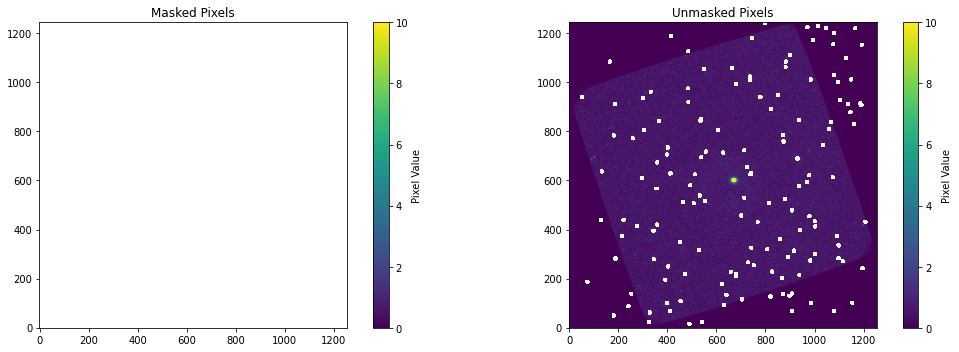

In [23]:
identifier = StarIdentifier()
hdulpath = '/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz'
hdul = fits.open(hdulpath)
image = hdul[1].data
wcs = WCS(hdul[1].header)
star_mask = identifier.by_catalog(
    image=image,
    wcs=wcs,
    mag_limit=17,
    catalog='UCAC4',
    aperture_radius=5
)
hdul.close()
%matplotlib inline
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0,vmax=10)

In [20]:
identifier = StarIdentifier()
hdulpath = '/Volumes/ZexiWork/data/HST/29P/2021/26.fits'
hdul = fits.open(hdulpath)
image = hdul[1].data
wcs = WCS(hdul[1].header)
star_mask = identifier.by_catalog(
    image=image,
    wcs=wcs,
    mag_limit=17,
    catalog='GSC',
    aperture_radius=5
)
hdul.close()
%matplotlib qt
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0,vmax=2)

Querying GSC 2.3 catalog...
GSC 2.3 query completed


In [17]:
#import sys
#import os
#sys.path.append(os.path.abspath('../'))

from astropy.io import fits
from uvotimgpy.base.region import RegionSelector

%matplotlib qt

hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/24.fits')
image = hdul[1].data
    
selector = RegionSelector(image)
apertures = selector.get_regions()

Manually identify

In [18]:
for aperture in apertures:
    print(aperture)

Region: CirclePixelRegion
center: PixCoord(x=993.0497835497831, y=1272.365800865801)
radius: 10
Region: CirclePixelRegion
center: PixCoord(x=698.6774891774887, y=889.6818181818182)
radius: 10


Creating selector...
Getting regions...
Regions obtained.


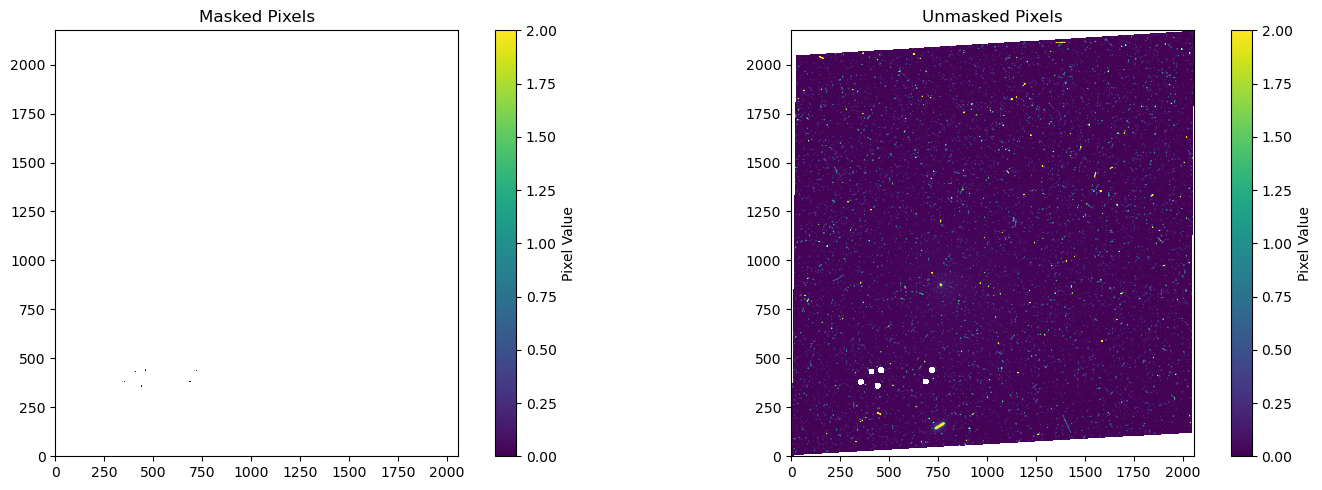

In [34]:
# 导入所需模块
import importlib
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier
from uvotimgpy.base.visualizer import MaskInspector
from astropy.io import fits
import matplotlib.pyplot as plt

# 确保使用Qt后端
%matplotlib qt

# 读取图像
hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/24.fits')
image = hdul[1].data

# 创建StarIdentifier实例并调用by_manual方法
identifier = StarIdentifier()
star_mask = identifier.by_manual(
    image=image,
    row_range=(300, 500),
    col_range=(300, 500)
)
hdul.close()

# 使用MaskInspector查看结果
%matplotlib inline
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0, vmax=2)

In [7]:
# 导入所需模块
import importlib
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier, PixelFiller
from uvotimgpy.base.visualizer import MaskInspector
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from regions import CirclePixelRegion, PixCoord

%matplotlib qt

# 读取图像
hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/24.fits')
image = hdul[1].data

# 创建一个小的测试区域
#test_region = image[300:400, 300:400]

# 创建StarIdentifier实例并获取mask
identifier = StarIdentifier()
center = PixCoord(x=400, y=400)
circle_region = CirclePixelRegion(center=center, radius=15)
star_mask = identifier.by_manual(
    image=image,
    row_range=(300, 500),
    col_range=(300, 500),
    region_plot=circle_region,
)

print(star_mask)

Creating selector...
Getting regions...
Regions obtained.
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


nearest method:
  Average time: 0.655 ± 0.005 seconds
  Best time: 0.651 seconds
  Worst time: 0.665 seconds

biharmonic method:
  Average time: 0.005 ± 0.000 seconds
  Best time: 0.005 seconds
  Worst time: 0.005 seconds



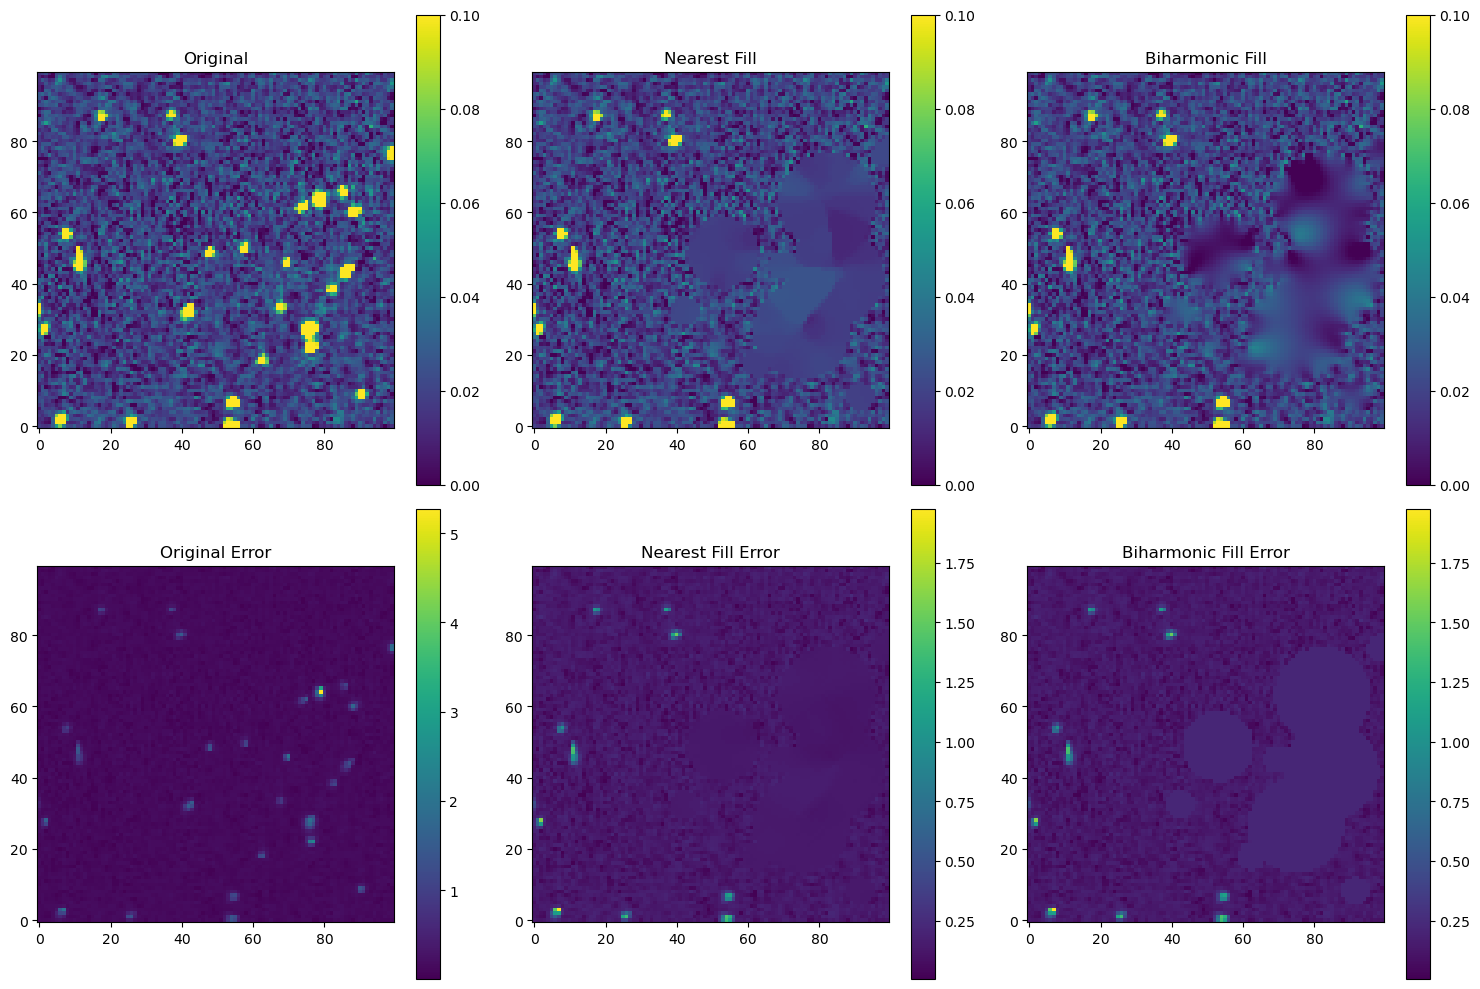

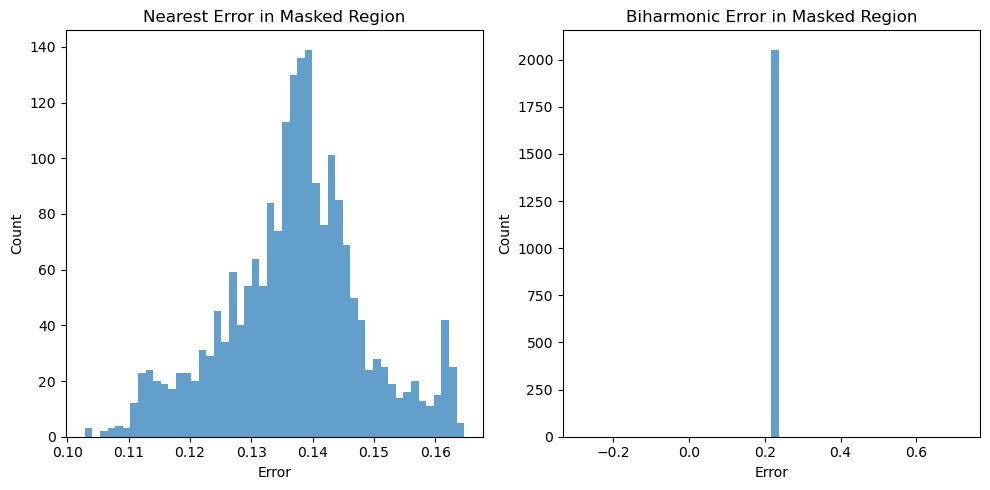

In [55]:
# 导入所需模块
import importlib
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier, PixelFiller
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import time


# 创建模拟的误差数组（这里用泊松噪声作为示例）
error = np.sqrt(np.abs(test_region))  # 假设每个像素的误差是其值的平方根


# 使用PixelFiller测试不同的填充方法
filler = PixelFiller()

# 测试两种方法的执行时间和结果
methods = ['nearest', 'biharmonic']
results = {}

for method in methods:
    # 运行多次取平均
    times = []
    n_runs = 5
    
    for _ in range(n_runs):
        start_time = time.time()
        if method == 'nearest':
            filled_img, filled_err = filler.by_neighbors(
                test_region, 
                star_mask, 
                radius=4, 
                method=method,
                error=error
            )
        else:
            filled_img, filled_err = filler.by_neighbors(
                test_region, 
                star_mask, 
                method=method,
                error=error
            )
        end_time = time.time()
        times.append(end_time - start_time)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    print(f"{method} method:")
    print(f"  Average time: {avg_time:.3f} ± {std_time:.3f} seconds")
    print(f"  Best time: {min(times):.3f} seconds")
    print(f"  Worst time: {max(times):.3f} seconds")
    print()
    
    results[method] = (filled_img, filled_err)

# 显示结果比较
%matplotlib inline
plt.figure(figsize=(15, 10))

# 第一行：原始图像和填充结果
plt.subplot(231)
plt.title('Original')
plt.imshow(test_region, vmin=0, vmax=0.1, origin='lower')
plt.colorbar()

plt.subplot(232)
plt.title('Nearest Fill')
plt.imshow(results['nearest'][0], vmin=0, vmax=0.1, origin='lower')
plt.colorbar()

plt.subplot(233)
plt.title('Biharmonic Fill')
plt.imshow(results['biharmonic'][0], vmin=0, vmax=0.1, origin='lower')
plt.colorbar()

# 第二行：原始误差和填充后的误差
plt.subplot(234)
plt.title('Original Error')
plt.imshow(error, origin='lower')
plt.colorbar()

plt.subplot(235)
plt.title('Nearest Fill Error')
plt.imshow(results['nearest'][1], origin='lower')
plt.colorbar()

plt.subplot(236)
plt.title('Biharmonic Fill Error')
plt.imshow(results['biharmonic'][1], origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

# 显示mask区域的误差分布
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Nearest Error in Masked Region')
plt.hist(results['nearest'][1][star_mask].ravel(), bins=50, alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Count')

plt.subplot(122)
plt.title('Biharmonic Error in Masked Region')
plt.hist(results['biharmonic'][1][star_mask].ravel(), bins=50, alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

hdul.close()

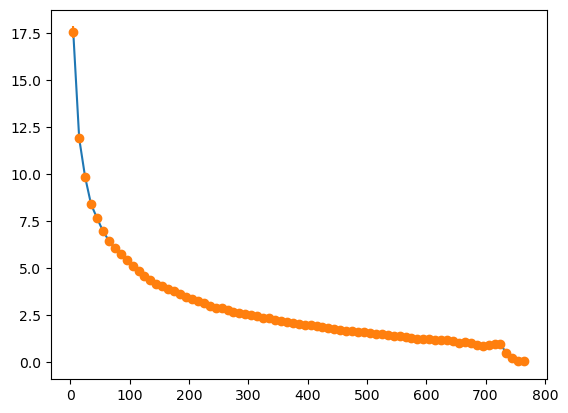

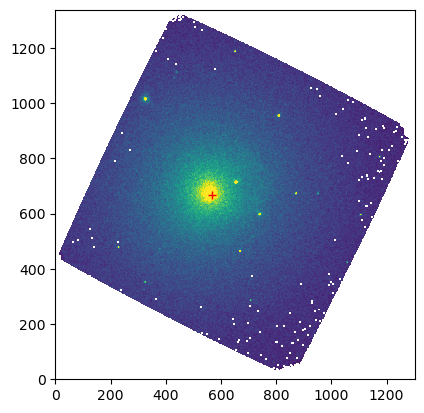

In [32]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

from uvotimgpy.utils.image_operation import calc_radial_profile
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

filepath = '/Volumes/ZexiWork/data/Swift/46p/00094384002/uvot/image/sw00094384002uw1_sk.img.gz'
hdul = fits.open(filepath)
image = hdul[1].data
image[image==0] = np.nan

center = (567.8342385308982-1,	667.9202314972873-1)
step = 10
image_error = np.sqrt(image)

r, intensity, errors = calc_radial_profile(image, center, step=step, image_error=image_error, start=0)

plt.plot(r, intensity)
plt.errorbar(r, intensity, yerr=errors, fmt='o')
plt.show()

plt.imshow(image, vmin=0, vmax=10, origin='lower')
plt.plot(center[0], center[1], 'r+')
plt.show()
